In [1]:
from glotaran_tools.specification_parser import parse_yml
from glotaran_core.model import Dataset
from glotaran_models.kinetic import KineticSeperableModel
import numpy as np
from lmfit import Parameters
# Imports for plotting

import matplotlib.pyplot as plt
%matplotlib notebook

test_parameter = [101e-4, 0.1, 10]
test_amps = [1,2,3]
times = np.asarray(np.arange(-50, 1500, 1.5))

fitspec = '''
type: kinetic

parameter: {}

compartments: [s1, s2, s3]

megacomplexes:
    - label: mc1
      k_matrices: [k1]
      
k_matrices:
  - label: "k1"
    matrix: {{
      '("s1","s1")': 1,
}}

irf:
  - label: irf1
    type: gaussian
    center: 2
    width: 3
datasets: 
  - label: dataset1
    type: spectral
    megacomplexes: [mc1]
    path: 'data/dataset1.ascii'
    irf: irf1

'''
model = parse_yml(fitspec.format(test_parameter))
print(model)

Modeltype: Kinetic

Parameter
---------

Index: 1 Initial Value: 0.0101 Label: None
Index: 2 Initial Value: 0.1 Label: None
Index: 3 Initial Value: 10.0 Label: None

Megacomplexes
-------------

Label: mc1
K-Matrices: ['k1']

Datasets
--------

Dataset 'dataset1'

	Dataset Scaling: None
	Initial Concentration: None
	Megacomplexes: ['mc1']

	Irf: irf1


K-Matrices
----------

Label: k1
Matrix:
[[1]]


IRFs
----

Label: irf1 Type: 'Gaussian' Center: [2] Width: [3] Center Dispersion: [] Width Dispersion [] Scale: [], Nomalize: True



In [2]:
simparams = Parameters()
simparams.add("p1", 101e-5)
#simparams.add("p2",802e-5)
#simparams.add("p3",505e-5)
simparams.add("p2",0.3)
simparams.add("p3",21.4)
simparams.pretty_print()

Name     Value      Min      Max   Stderr     Vary     Expr
p1   0.00101     -inf      inf     None     True     None
p2       0.3     -inf      inf     None     True     None
p3      21.4     -inf      inf     None     True     None


In [3]:
fitmodel = KineticSeperableModel(model)
fitmodel.get_initial_fitting_parameter().pretty_print()

Name     Value      Min      Max   Stderr     Vary     Expr
p1    0.0101     -inf      inf     None     True     None
p2       0.1     -inf      inf     None     True     None
p3        10     -inf      inf     None     True     None


<IPython.core.display.Javascript object>


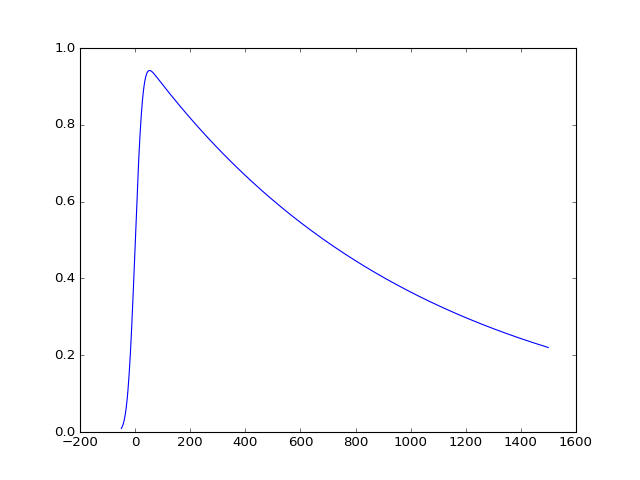

In [4]:
data = fitmodel.eval(simparams, *times, **{'dataset':'dataset1'})

fig = plt.figure()
plt.plot(times, data[:, 0])

In [5]:
result = fitmodel.fit(fitmodel.get_initial_fitting_parameter(), 
                      *times, 
                      **{"data": data}
                     )
result.best_fit_parameter.pretty_print()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0294e+02                                    4.32e+03    
       1              2         7.1279e+01      3.17e+01       5.40e+00       5.23e+04    
       2              3         6.6992e+00      6.46e+01       1.00e+01       2.46e+04    
       3              4         1.0851e-01      6.59e+00       1.48e+01       2.61e+03    
       4              5         1.0957e-04      1.08e-01       3.26e+00       3.78e+01    
       5              6         4.4127e-10      1.10e-04       1.82e-01       4.39e-02    
       6              7         3.8909e-21      4.41e-10       3.23e-04       1.76e-07    
       7              8         7.8766e-28      3.89e-21       1.26e-09       2.53e-12    
`gtol` termination condition is satisfied.
Function evaluations 8, initial cost 1.0294e+02, final cost 7.8766e-28, first-order optimality 2.53e-12.
Name     Value      Min      Max 

<IPython.core.display.Javascript object>


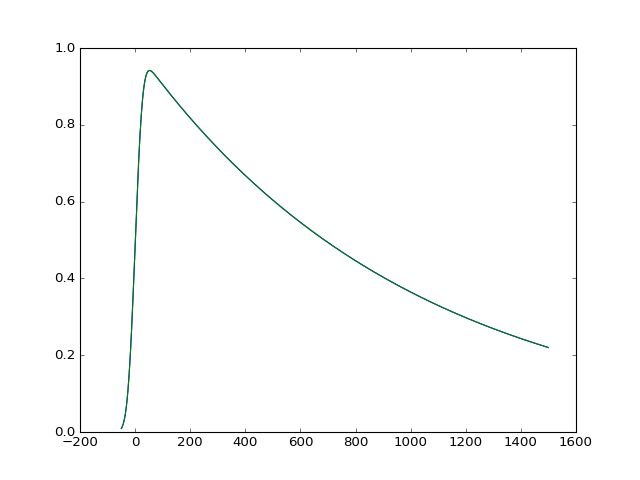

(1034, 1)
(1034, 1)


In [6]:
fitted_data = fitmodel.eval(result.best_fit_parameter, *times, **{'dataset':'dataset1'})
fig = plt.figure()
print(data.shape)
print(fitted_data.shape)
plt.plot(times, data[:, 0])
plt.plot(times, fitted_data[:, 0])

In [7]:
result.eval(*times, **{"data": data})

array([[  2.10589521e-17,  -8.01024236e-19,  -1.09017251e-18, ...,
         -2.53796227e-19,   2.69888899e-19,   2.76910622e-19],
       [  2.53632740e-17,  -9.64748726e-19,  -1.31299715e-18, ...,
         -3.05670635e-19,   3.25052551e-19,   3.33509472e-19],
       [  3.04123044e-17,  -1.15679986e-18,  -1.57437361e-18, ...,
         -3.66520048e-19,   3.89760294e-19,   3.99900721e-19],
       ..., 
       [  4.99379103e-16,  -1.89949985e-17,  -2.58516838e-17, ...,
         -6.01836842e-18,   6.39998020e-18,   6.56648903e-18],
       [  4.98623116e-16,  -1.89662429e-17,  -2.58125482e-17, ...,
         -6.00925750e-18,   6.39029157e-18,   6.55654833e-18],
       [  4.97868274e-16,  -1.89375308e-17,  -2.57734718e-17, ...,
         -6.00016036e-18,   6.38061760e-18,   6.54662268e-18]])

<IPython.core.display.Javascript object>


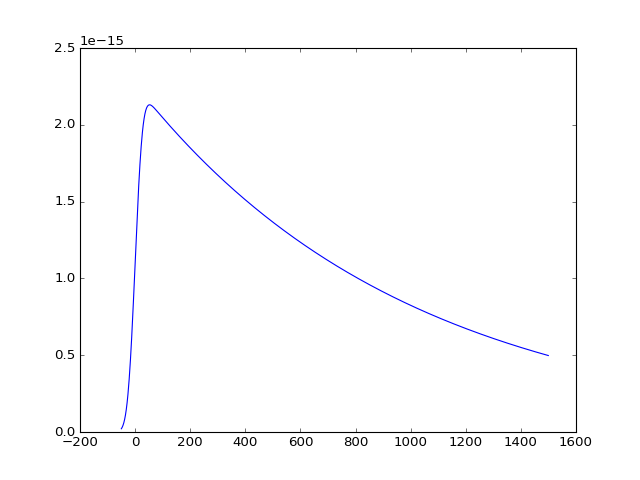

(1034, 1)
(1034, 1)


In [8]:
reconstructed_data = result.eval(*times, **{"data": data})
fig = plt.figure()
print(data.shape)
print(fitted_data.shape)
#plt.plot(times, data[:, 0])
plt.plot(times, reconstructed_data[:, 0])